
# Phân tích Thuật toán Cuckoo Search (CS)


**Mục tiêu:**
1.  Trình bày chi tiết về thuật toán Cuckoo Search (CS).
2.  Triển khai thuật toán CS **chỉ bằng NumPy**.
3.  Thử nghiệm CS trên các hàm tối ưu liên tục.
4.  Trực quan hóa kết quả và so sánh với thuật toán khác.

In [1]:
# Import các thư viện
import numpy as np
import matplotlib.pyplot as plt
import time
import math
GLOBAL_RNG = np.random.default_rng(seed=42) # Cài đặt bộ sinh số ngẫu nhiên

## 1. Trình bày chi tiết về Thuật toán Cuckoo Search

Cuckoo Search (CS) là một thuật toán tối ưu hóa metaheuristic (siêu heuristic) được phát triển bởi Xin-She Yang và Suash Deb vào năm 2009. Thuật toán này lấy cảm hứng từ hành vi ký sinh của loài chim cu (cuckoo).

### Nguồn cảm hứng

Thuật toán mô phỏng chiến lược sinh sản "ký sinh tổ" của chim cu. Chim cu mái đẻ trứng của mình vào tổ của một loài chim khác (gọi là chim chủ). Những trường hợp xảy ra:
1.  Trứng chim cu nở trước, chim cu con sẽ đẩy trứng hoặc chim non của chim chủ ra khỏi tổ để nó được độc chiếm thức ăn.
2.  Chim chủ phát hiện ra trứng "lạ" (không giống trứng của mình) với một xác suất $p_a \in [0, 1]$. Nếu phát hiện, chim chủ sẽ vứt bỏ trứng lạ đó hoặc bỏ cả tổ và đi xây một tổ mới ở vị trí khác.

### Ba quy tắc của CS

Để đơn giản hóa mô hình, CS dựa trên ba quy tắc chính:

1.  **Một trứng mỗi lần:** Mỗi con chim cu chỉ đẻ một quả trứng tại một thời điểm và thả nó vào một tổ được chọn ngẫu nhiên.
2.  **Tổ tốt nhất:** Những tổ có trứng chất lượng tốt nhất (tương đương với giải pháp tốt nhất) sẽ được "nuôi dưỡng" và mang sang thế hệ tiếp theo.
3.  **Số lượng tổ cố định và xác suất phát hiện ( $p_a$ ):** Số lượng tổ chim chủ là cố định. Trứng lạ (giải pháp tệ hơn) sẽ bị chim chủ phát hiện với xác suất $p_a$. Khi bị phát hiện, tổ mới (giải pháp mới) sẽ được xây dựng ở vị trí mới.

### Hai thành phần cốt lõi của thuật toán

CS cân bằng giữa **khám phá** (exploration - tìm kiếm toàn cục) và **khai thác** (exploitation - tìm kiếm cục bộ) thông qua hai cơ chế chính:

#### a) Lévy Flights (Khám phá toàn cục)

Đây là thành phần quan trọng nhất của CS. Khi một con chim cu tạo ra một giải pháp mới (đẻ trứng), nó không di chuyển một cách ngẫu nhiên đơn giản (như Gaussian random walk) mà sử dụng **Lévy flights** (bước nhảy Lévy).

* **Lévy flights** là một kiểu bước đi ngẫu nhiên mà các bước nhảy tuân theo phân phối Lévy—một phân phối "đuôi nặng" (heavy-tailed).
* Điều này có nghĩa là: Hầu hết các bước nhảy là **ngắn** (giúp tinh chỉnh cục bộ) nhưng thỉnh thoảng sẽ có một bước nhảy **rất dài** (giúp thoát khỏi cực tiểu địa phương và khám phá các vùng xa xôi của không gian tìm kiếm).



Trong lập trình, bước nhảy Lévy $s$ thường được tính bằng giải thuật Mantegna:
$$s = \frac{u}{|v|^{1/\beta}}$$
Trong đó:
* $u \sim N(0, \sigma_u^2)$ và $v \sim N(0, \sigma_v^2)$ (lấy từ phân phối chuẩn).
* $\beta$ là một tham số (thường là 1.5).

Giải pháp mới (tổ mới $x^{t+1}$) được tạo từ giải pháp cũ ($x^t$) theo công thức:
$$x_i^{t+1} = x_i^t + \alpha \cdot s$$
(Trong đó $\alpha$ là kích thước bước, thường liên quan đến `step_size`).

#### b) Phát hiện ngẫu nhiên (Khai thác cục bộ & Ngẫu nhiên hóa)

Đây là thành phần thứ hai, mô phỏng việc chim chủ phát hiện trứng lạ với xác suất $p_a$.

* Tại mỗi thế hệ, một phần (tỷ lệ $p_a$) các tổ tệ nhất sẽ bị "loại bỏ".
* Các tổ mới được tạo ra để thay thế chúng. Các tổ mới này thường được tạo ra bằng cách kết hợp thông tin từ hai tổ ngẫu nhiên khác.
* Hành động này giúp tăng cường sự đa dạng của quần thể và tinh chỉnh cục bộ xung quanh các giải pháp hiện có.

### Mã giả Cuckoo Search

1.  **Khởi tạo:**
    * Tạo `N` tổ (giải pháp) $x_i$ ngẫu nhiên.
    * Tìm giải pháp tốt nhất ban đầu $g_{best}$.

2.  **Vòng lặp (cho mỗi thế hệ):**

    * **Pha 1: Lévy Flights (Tìm kiếm toàn cục)**
        * `CHO` mỗi tổ $i$:
            * Tạo một giải pháp mới $x_{new}$ bằng bước nhảy Lévy từ $x_i$.
            * Chọn ngẫu nhiên một tổ $j$.
            * `NẾU` $x_{new}$ tốt hơn $x_j$, `THÌ` thay thế $x_j = x_{new}$.

    * **Pha 2: Phát hiện trứng (Tìm kiếm cục bộ)**
        * Loại bỏ $pa$ % số tổ *tệ nhất*.
        * Thay thế chúng bằng các tổ mới (được tạo bằng cách kết hợp 2 tổ ngẫu nhiên khác).

    * **Cập nhật:**
        * Tìm $g_{best}$ mới trong toàn bộ $N$ tổ hiện tại.

3.  **Kết thúc:**
    * Trả về $g_{best}$.

## 2. Triển khai thuật toán CS bằng Numpy


In [2]:
class CuckooSearch:
    def __init__(self, n_cuckoos=25, n_iterations=1000, pa=0.25,
                 beta=1.5, step_size=0.1, random_state=None):
        self.n_cuckoos = n_cuckoos
        self.n_iterations = n_iterations
        self.pa = pa
        self.beta = beta
        self.step_size = step_size

        if random_state:
            self.rng = random_state
        else:
            self.rng = np.random.default_rng()

    def _get_levy_flight_step(self, n_dims):
        try:
            from math import lgamma
            num = np.exp(lgamma(1 + self.beta)) * np.sin(np.pi * self.beta / 2)
            den = np.exp(lgamma((1 + self.beta) / 2)) * self.beta * (2 ** ((self.beta - 1) / 2))
            sigma = (num / den) ** (1 / self.beta)
        except ImportError:
            sigma = 0.69656

        u = self.rng.normal(0, sigma, n_dims)
        v = self.rng.normal(0, 1, n_dims)
        step = u / (np.abs(v) ** (1 / self.beta))
        return step

    def fit(self, objective_func, bounds):
        print(f"Chạy Cuckoo Search (N={self.n_cuckoos}, Iter={self.n_iterations})...")
        start_time = time.time()

        n_dims = bounds.shape[0]
        min_bound = bounds[:, 0]
        max_bound = bounds[:, 1]

        # 1. Khởi tạo N tổ ngẫu nhiên
        nests = self.rng.uniform(min_bound, max_bound, (self.n_cuckoos, n_dims))
        fitness = np.array([objective_func(nest) for nest in nests])

        best_nest_idx = np.argmin(fitness)
        best_fitness = fitness[best_nest_idx]
        best_solution = nests[best_nest_idx].copy()

        fitness_history = [best_fitness]

        # 2. Vòng lặp chính
        for iteration in range(self.n_iterations):

            # Pha 1: Lévy Flights (Global Search)
            for i in range(self.n_cuckoos):
                current_nest = nests[i].copy()

                # Tạo giải pháp mới bằng Lévy flight
                step = self._get_levy_flight_step(n_dims)
                new_nest = current_nest + self.step_size * step
                new_nest = np.clip(new_nest, min_bound, max_bound) # Áp dụng ràng buộc

                new_fitness = objective_func(new_nest)

                # Chọn một tổ j ngẫu nhiên và so sánh
                j = self.rng.integers(0, self.n_cuckoos)
                if new_fitness < fitness[j]:
                    nests[j] = new_nest
                    fitness[j] = new_fitness

            #  Pha 2: Phát hiện trứng (pa)
            # Phiên bản đơn giản hóa:
            # Sắp xếp và thay thế pa% tổ tệ nhất bằng tổ mới
            sorted_indices = np.argsort(fitness)
            n_abandon = int(self.pa * self.n_cuckoos)

            # Chỉ số của các tổ tệ nhất
            worst_indices = sorted_indices[-n_abandon:]

            for i in worst_indices:
                # Tạo tổ mới thay thế bằng cách kết hợp 2 tổ ngẫu nhiên
                j, k = self.rng.choice(self.n_cuckoos, 2, replace=False)
                step = self.rng.random() * (nests[j] - nests[k])
                new_nest = nests[i] + step
                new_nest = np.clip(new_nest, min_bound, max_bound)

                nests[i] = new_nest
                fitness[i] = objective_func(new_nest)

            # Cập nhật giải pháp tốt nhất toàn cục
            current_best_idx = np.argmin(fitness)
            if fitness[current_best_idx] < best_fitness:
                best_fitness = fitness[current_best_idx]
                best_solution = nests[current_best_idx].copy()

            fitness_history.append(best_fitness)

        end_time = time.time()
        print(f"CS hoàn thành. Thời gian: {end_time - start_time:.4f}s. Fitness tốt nhất: {best_fitness:.6f}")
        return best_solution, best_fitness, fitness_history

## 3. Thử nghiệm CS trên các hàm liên tục

Chúng ta sẽ định nghĩa các hàm Sphere, Rastrigin, Rosenbrock và chạy thuật toán CS trên chúng.

In [3]:

def sphere_function(x):
    return np.sum(x**2)

def rastrigin_function(x):
    A = 10
    n = len(x)
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def rosenbrock_function(x):
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

N_DIMENSIONS = 10     # Số chiều của vấn đề
N_ITERATIONS = 1000   # Số thế hệ

benchmark_functions = [
    {
        "name": "Sphere Function",
        "func": sphere_function,
        "bounds": np.array([[-10.0, 10.0]] * N_DIMENSIONS),
        "step_size": 0.1
    },
    {
        "name": "Rastrigin Function",
        "func": rastrigin_function,
        "bounds": np.array([[-5.12, 5.12]] * N_DIMENSIONS),
        "step_size": 0.05 # Cần bước nhảy nhỏ hơn
    },
    {
        "name": "Rosenbrock Function",
        "func": rosenbrock_function,
        "bounds": np.array([[-5.0, 10.0]] * N_DIMENSIONS),
        "step_size": 0.05
    }
]

results_history_cs = {}

print("Bắt đầu chạy thử nghiệm Cuckoo Search")
for bench in benchmark_functions:
    print(f"\nĐang chạy hàm: {bench['name']} ({N_DIMENSIONS} chiều)")
    cs_optimizer = CuckooSearch(
        n_cuckoos=30,
        n_iterations=N_ITERATIONS,
        pa=0.25,
        step_size=bench["step_size"],
        random_state=GLOBAL_RNG
    )

    # Chạy và lưu kết quả
    best_sol, best_fit, history = cs_optimizer.fit(bench["func"], bench["bounds"])
    results_history_cs[bench['name']] = history

    # In 5 giá trị đầu của vector giải pháp
    print(f"Giải pháp tốt nhất (5 giá trị đầu): {best_sol[:5]}...")


Bắt đầu chạy thử nghiệm Cuckoo Search

Đang chạy hàm: Sphere Function (10 chiều)
Chạy Cuckoo Search (N=30, Iter=1000)...
CS hoàn thành. Thời gian: 1.4204s. Fitness tốt nhất: 0.002161
Giải pháp tốt nhất (5 giá trị đầu): [-0.01393281  0.01677783 -0.00706377 -0.00766225  0.00901952]...

Đang chạy hàm: Rastrigin Function (10 chiều)
Chạy Cuckoo Search (N=30, Iter=1000)...
CS hoàn thành. Thời gian: 1.9962s. Fitness tốt nhất: 5.950424
Giải pháp tốt nhất (5 giá trị đầu): [-1.01065022 -0.01044605 -1.00794555  1.02202569 -0.02014537]...

Đang chạy hàm: Rosenbrock Function (10 chiều)
Chạy Cuckoo Search (N=30, Iter=1000)...
CS hoàn thành. Thời gian: 3.3711s. Fitness tốt nhất: 1.666787
Giải pháp tốt nhất (5 giá trị đầu): [0.97368306 1.00126988 0.98326449 1.02860521 1.02161338]...


## 4. Trực quan hóa và So sánh

### 4a. Trực quan hóa kết quả của Cuckoo Search

Đầu tiên, chúng ta sẽ vẽ biểu đồ hội tụ của CS trên cả 3 hàm vừa chạy.

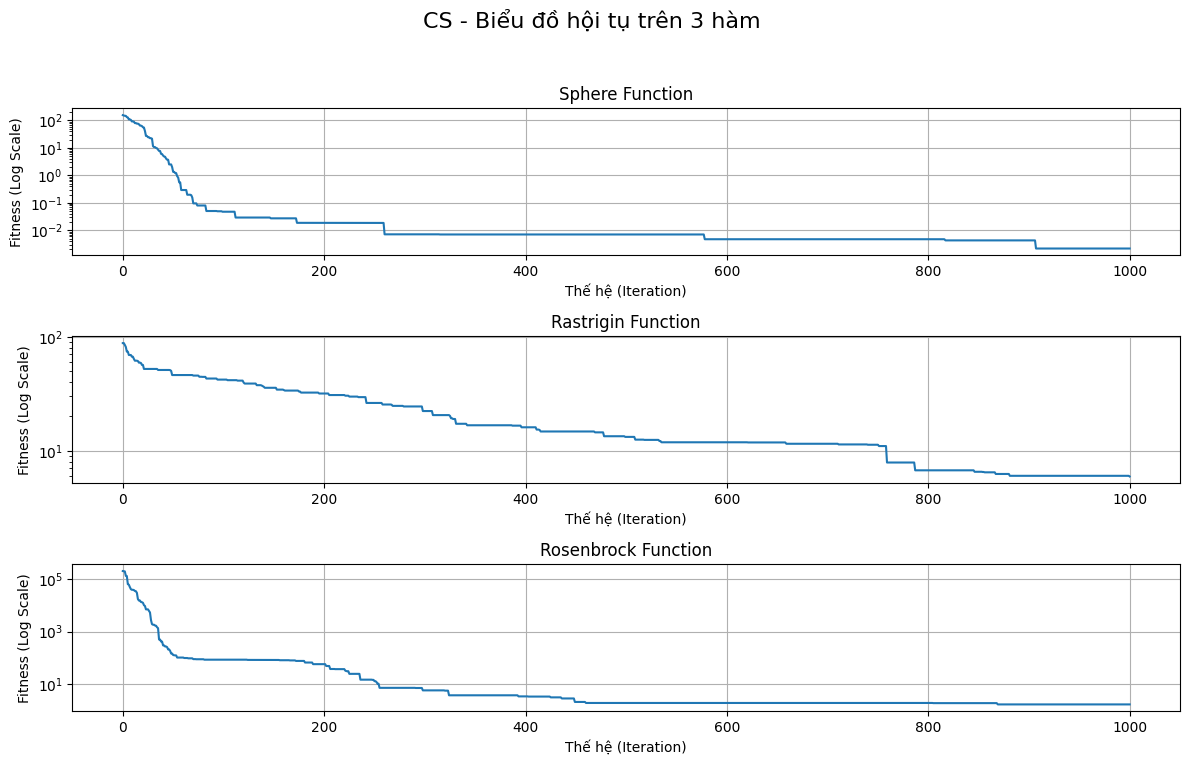

In [4]:
#
plt.figure(figsize=(12, 8))
plt.suptitle("CS - Biểu đồ hội tụ trên 3 hàm ", fontsize=16)

# Vẽ biểu đồ cho từng hàm
for i, (name, history) in enumerate(results_history_cs.items()):
    ax = plt.subplot(len(results_history_cs), 1, i + 1)
    ax.plot(history)
    ax.set_title(name)
    ax.set_xlabel("Thế hệ (Iteration)")
    ax.set_ylabel("Fitness (Log Scale)")
    ax.set_yscale('log')
    ax.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4b. So sánh với Thuật toán khác (Genetic Algorithm - GA)

Chúng ta sẽ triển khai **Genetic Algorithm (GA)** (cũng chỉ bằng NumPy)
để so sánh hiệu suất với CS.

GA này sẽ sử dụng:
* **Selection:** Tournament Selection.
* **Crossover:** Simulated Binary Crossover (SBX) (tốt cho bài toán liên tục).
* **Mutation:** Polynomial Mutation.

In [5]:
class GeneticAlgorithm:
    def __init__(self, n_population=50, n_iterations=1000,
                 crossover_rate=0.9, mutation_rate=0.1,
                 tournament_size=3, eta_crossover=15, eta_mutation=20,
                 random_state=None):
        self.n_population = n_population
        self.n_iterations = n_iterations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.eta_c = eta_crossover
        self.eta_m = eta_mutation
        if random_state:
            self.rng = random_state
        else:
            self.rng = np.random.default_rng()

    def _tournament_selection(self, population, fitness):
        indices = self.rng.choice(self.n_population, self.tournament_size, replace=False)
        tournament_fitness = fitness[indices]
        winner_idx = indices[np.argmin(tournament_fitness)]
        return population[winner_idx]

    def _sbx_crossover(self, parent1, parent2, min_bound, max_bound):
        child1, child2 = parent1.copy(), parent2.copy()
        if self.rng.random() > self.crossover_rate:
            return child1, child2

        for i in range(len(parent1)):
            if self.rng.random() > 0.5: continue
            u = self.rng.random()
            beta = (2 * u) ** (1 / (self.eta_c + 1)) if u <= 0.5 else (1 / (2 * (1 - u))) ** (1 / (self.eta_c + 1))
            c1 = 0.5 * ((1 + beta) * parent1[i] + (1 - beta) * parent2[i])
            c2 = 0.5 * ((1 - beta) * parent1[i] + (1 + beta) * parent2[i])
            child1[i] = np.clip(c1, min_bound[i], max_bound[i])
            child2[i] = np.clip(c2, min_bound[i], max_bound[i])
        return child1, child2

    def _polynomial_mutation(self, individual, min_bound, max_bound):
        mutated = individual.copy()
        for i in range(len(individual)):
            if self.rng.random() < self.mutation_rate:
                u = self.rng.random()
                delta = (2 * u) ** (1 / (self.eta_m + 1)) - 1 if u < 0.5 else 1 - (2 * (1 - u)) ** (1 / (self.eta_m + 1))
                mutated[i] = individual[i] + delta * (max_bound[i] - min_bound[i]) # Sửa lỗi nhỏ ở đây
                mutated[i] = np.clip(mutated[i], min_bound[i], max_bound[i])
        return mutated

    def fit(self, objective_func, bounds):
        print(f"Genetic Algorithm (N={self.n_population}, Iter={self.n_iterations})...")
        start_time = time.time()

        n_dims = bounds.shape[0]
        min_bound = bounds[:, 0]
        max_bound = bounds[:, 1]

        population = self.rng.uniform(min_bound, max_bound, (self.n_population, n_dims))
        fitness = np.array([objective_func(ind) for ind in population])

        best_fitness = np.min(fitness)
        fitness_history = [best_fitness]

        for iteration in range(self.n_iterations):
            new_population = []
            while len(new_population) < self.n_population:
                parent1 = self._tournament_selection(population, fitness)
                parent2 = self._tournament_selection(population, fitness)
                child1, child2 = self._sbx_crossover(parent1, parent2, min_bound, max_bound)
                child1 = self._polynomial_mutation(child1, min_bound, max_bound)
                child2 = self._polynomial_mutation(child2, min_bound, max_bound)
                new_population.extend([child1, child2])

            population = np.array(new_population[:self.n_population])
            fitness = np.array([objective_func(ind) for ind in population])

            current_best_fitness = np.min(fitness)
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness

            fitness_history.append(best_fitness)

        end_time = time.time()
        print(f"GA hoàn thành. Thời gian: {end_time - start_time:.4f}s. Fitness tốt nhất: {best_fitness:.6f}")
        return None, best_fitness, fitness_history

In [6]:

N_DIMENSIONS_COMPARE = 10
N_ITERATIONS_COMPARE = 1000
POP_SIZE_COMPARE = 50

# Lấy thông số cho Rastrigin
bench_rastrigin = benchmark_functions[1]
FUNC = bench_rastrigin["func"]
BOUNDS = bench_rastrigin["bounds"]

comparison_rng_cs = np.random.default_rng(seed=123)
comparison_rng_ga = np.random.default_rng(seed=123)

print(" So sánh CS vs GA ")
print(f"Bài toán: Rastrigin {N_DIMENSIONS_COMPARE}D, {N_ITERATIONS_COMPARE} Iterations, PopSize={POP_SIZE_COMPARE}")

cs_comparator = CuckooSearch(
    n_cuckoos=POP_SIZE_COMPARE,
    n_iterations=N_ITERATIONS_COMPARE,
    step_size=bench_rastrigin["step_size"],
    random_state=comparison_rng_cs
)
_, cs_best_fit, cs_history = cs_comparator.fit(FUNC, BOUNDS)

ga_comparator = GeneticAlgorithm(
    n_population=POP_SIZE_COMPARE,
    n_iterations=N_ITERATIONS_COMPARE,
    mutation_rate=0.05,
    random_state=comparison_rng_ga
)
_, ga_best_fit, ga_history = ga_comparator.fit(FUNC, BOUNDS)

print("\n Kết quả so sánh ")
print(f"CS Best Fitness: {cs_best_fit:.6f}")
print(f"GA Best Fitness: {ga_best_fit:.6f}")

 So sánh CS vs GA 
Bài toán: Rastrigin 10D, 1000 Iterations, PopSize=50
Chạy Cuckoo Search (N=50, Iter=1000)...
CS hoàn thành. Thời gian: 2.7104s. Fitness tốt nhất: 5.300728
Genetic Algorithm (N=50, Iter=1000)...
GA hoàn thành. Thời gian: 4.0226s. Fitness tốt nhất: 0.000000

 Kết quả so sánh 
CS Best Fitness: 5.300728
GA Best Fitness: 0.000000


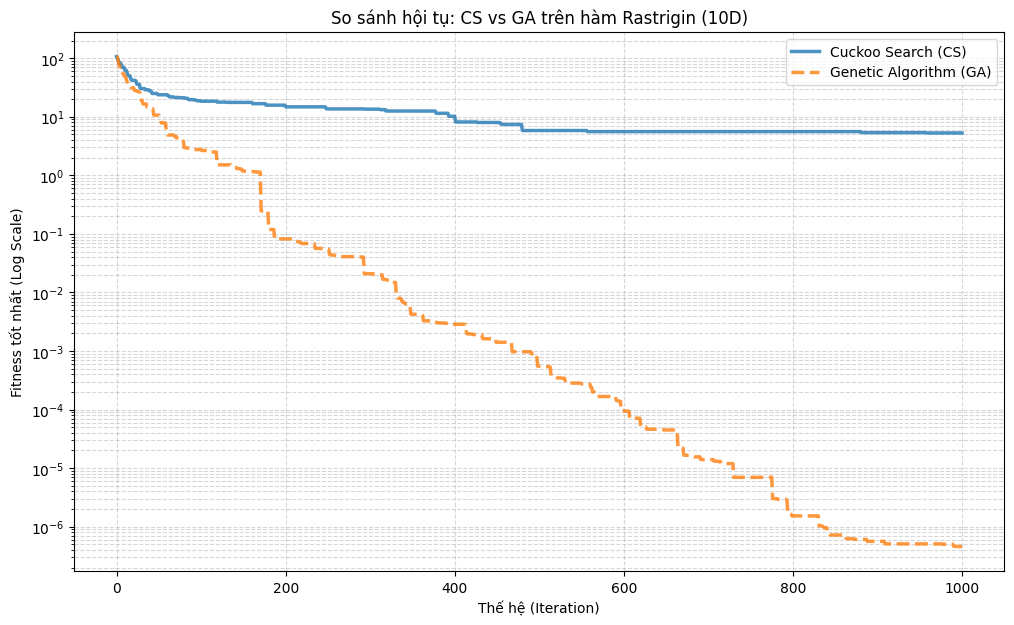

In [7]:

plt.figure(figsize=(12, 7))
plt.plot(cs_history, label="Cuckoo Search (CS)", linewidth=2.5, alpha=0.8)
plt.plot(ga_history, label="Genetic Algorithm (GA)", linewidth=2.5, linestyle='--', alpha=0.8)

plt.title(f"So sánh hội tụ: CS vs GA trên hàm Rastrigin ({N_DIMENSIONS_COMPARE}D)")
plt.xlabel("Thế hệ (Iteration)")
plt.ylabel("Fitness tốt nhất (Log Scale)")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()